In [1]:
import pandas as pd
import numpy as np
import re
import math
import pickle
import scipy
import matplotlib.pyplot as plt

from sklearn import metrics
from preprocessing import *
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from scipy.cluster import hierarchy as hc
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [2]:
# best = pickle.load(open('nb5_best.p','rb'))
X_train, y_train = pickle.load(open('train.p','rb'))
X_valid, y_valid = pickle.load(open('valid.p','rb'))
X_test, y_test = pickle.load(open('test.p','rb'))

In [3]:
Original_train_index = X_train.index
Original_valid_index = X_valid.index
Original_test_index = X_test.index

X_train = X_train.reset_index()
X_valid = X_valid.reset_index()
X_test = X_test.reset_index()

X_train = X_train.drop(['index'], axis=1)
X_valid = X_valid.drop(['index'], axis=1)
X_test = X_test.drop(['index'], axis=1)

In [4]:
X_train_housetype_3_index = X_train[X_train['housetype'] == 3].index
X_valid_housetype_3_index = X_valid[X_valid['housetype'] == 3].index
X_test_housetype_3_index = X_test[X_test['housetype'] == 3].index

In [5]:
X_train = X_train.loc[X_train_housetype_3_index]
y_train = y_train[X_train_housetype_3_index]
X_valid = X_valid.loc[X_valid_housetype_3_index]
y_valid = y_valid[X_valid_housetype_3_index]
X_test = X_test.loc[X_test_housetype_3_index]
y_test = y_test[X_test_housetype_3_index]

**Feature Importance**

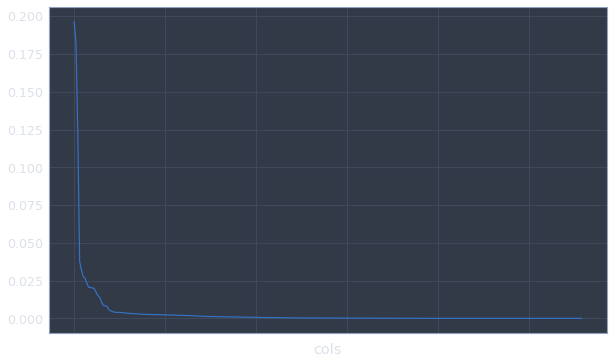

In [13]:
m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
# compute and plot the feature importance for all the columns in the dataframe
fi = rf_feat_importance(m, X_train)
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

**Analysis:** as usual, there are only a handful of columns that really account for the variance in prices we have in our dataset.  Let's inspect the larger values:

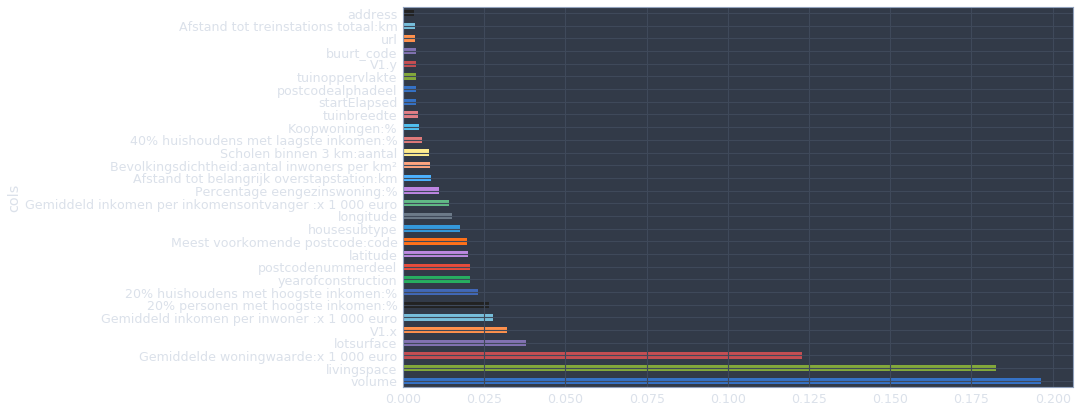

In [14]:
plot_fi(fi[:30]);

**Analysis:** perhaps not surpisingly, the factors that are driving price appear to be:

1) the size of the house <br>
2) the appraised value <br>
3) average income of residents <br>
4) house type (could be correlated with size) <br>
5) location (postcode, lat & lon)

Some of these are not housing attributes, per se, and aren't really all that interesting because they describe the people who live in the houses rather than the houses themselves.  If you trying to learn about which features are driving house prices, these aren't very helpful.  We'll explore in greater detail later.  For now, let's simplify the model by using only the most relevant information.

In [15]:
fi[:30]

,cols,imp
129,volume,0.196338
127,livingspace,0.182518
163,Gemiddelde woningwaarde:x 1 000 euro,0.122864
128,lotsurface,0.037763
1,V1.x,0.032045
154,Gemiddeld inkomen per inwoner :x 1 000 euro,0.027567
156,20% personen met hoogste inkomen:%,0.026491
159,20% huishoudens met hoogste inkomen:%,0.023145
136,yearofconstruction,0.020609
131,postcodenummerdeel,0.020520


In [16]:
# We'll use an importance of 0.0025 as a threshold for whether or not to retain a column and retrain the model
# using only these columns

to_keep = fi[fi.imp>0.0025].cols

X_train_2 = X_train[to_keep].copy()
X_valid_2 = X_valid[to_keep].copy()

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_2, y_train)
print_score(m, X_train_2, y_train, X_valid_2, y_valid)

[0.08135949523425293, 0.1721036356856285, 0.9505800760185695, 0.7958935443800412, 0.8055673392121389]


**Analysis:** Our previous best scores for validation and oob were 0.8566466844028794 and 0.8636396442979561.  Thus you can see our model has improved slightly.  Our r^2 value on the training set has also decreased slightly, indicating that we are now overfitting slightly less to the training data.

**Feature Importance 2**

now we examine FI for the simplified model.  Since we have likely removed alot of collinear columns, there is likely to be some change in the order of importance. 

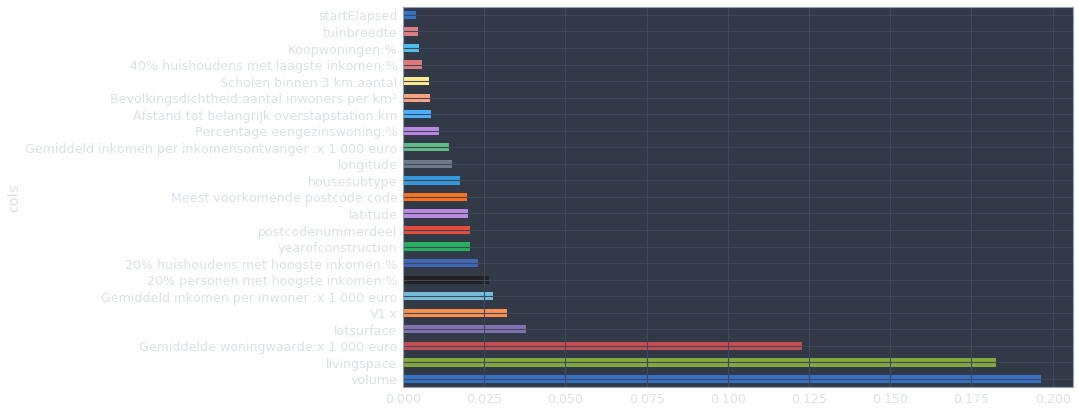

In [17]:
# original plot
plot_fi(fi[:23]);

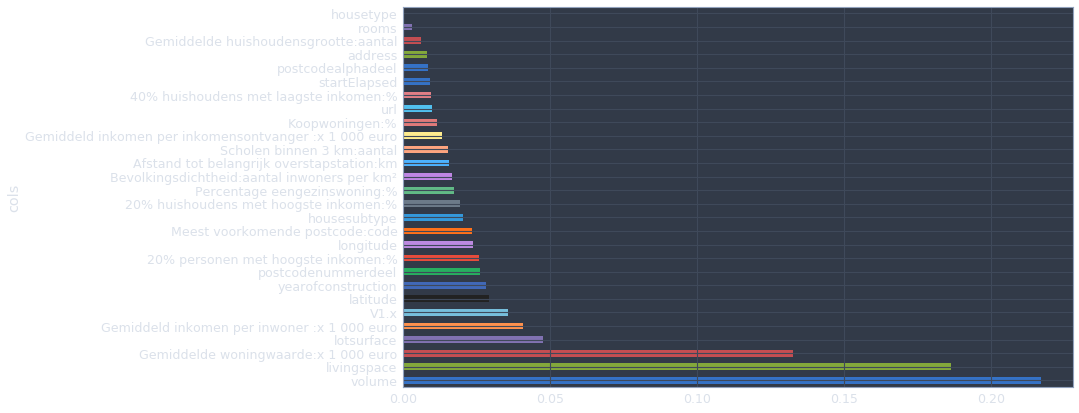

In [11]:
# new plot  

fi2 = rf_feat_importance(m, X_train_2)
plot_fi(fi2);

**Analysis:** The order really didn't change all that much, and the relative importances seem more or less the same.  Let's examine now the correlation between these features.

**Hierarchical Cluster Analysis**

In [12]:
corr = np.round(scipy.stats.spearmanr(X_train_2).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_2.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

/home/stefan/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/stefan/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/stefan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/stefan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/stefan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


ValueError: Distance matrix 'X' must be symmetric.

In [18]:
X_train_2.shape

(24506, 44)

**Analysis:** A few things jump out.  postcode number part, V1.x and most common postcode are all identical, thus 2 of these 3 can be dropped.  There's also a very high correlation between average income per income recipient and 20% people with highest income, as well as average house worth and 20% households with highest income (confirming what we said earlier).  Livingspace and volume are also highly correlated.  We should drop one and see the effect on r^2.

In [ ]:
m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_2.drop(['postcodenummerdeel','V1.x'],axis=1), y_train)
print_score(m, X_train_2.drop(['postcodenummerdeel','V1.x'],axis=1), y_train, X_valid_2.drop(['postcodenummerdeel','V1.x'],axis=1), y_valid)

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_2.drop(['postcodenummerdeel','Meest voorkomende postcode:code'],axis=1), y_train)
print_score(m, X_train_2.drop(['postcodenummerdeel','Meest voorkomende postcode:code'],axis=1), y_train, X_valid_2.drop(['postcodenummerdeel','Meest voorkomende postcode:code'],axis=1), y_valid)

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_2.drop(['V1.x','Meest voorkomende postcode:code'],axis=1), y_train)
print_score(m, X_train_2.drop(['V1.x','Meest voorkomende postcode:code'],axis=1), y_train, X_valid_2.drop(['V1.x','Meest voorkomende postcode:code'],axis=1), y_valid)

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_2.drop(['livingspace'],axis=1), y_train)
print_score(m, X_train_2.drop(['livingspace'],axis=1), y_train, X_valid_2.drop(['livingspace'],axis=1), y_valid)

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_2.drop(['volume'],axis=1), y_train)
print_score(m, X_train_2.drop(['volume'],axis=1), y_train, X_valid_2.drop(['volume'],axis=1), y_valid)

**Analysis:** getting ride of the postcode duplicates doesn't seem to really affect r^2 all that much.  The combination of living space and volume was slighty more predictive than one vs. the other, so we'll keep both (for now)

In [ ]:
X_train = X_train.drop(['postcodenummerdeel','Meest voorkomende postcode:code'], axis=1)
X_valid = X_valid.drop(['postcodenummerdeel','Meest voorkomende postcode:code'], axis=1)
X_test = X_test.drop(['postcodenummerdeel','Meest voorkomende postcode:code'], axis=1)

**Further Feature Removal**

Next we'll find all features that have something to do with the amount of money people make or the value of homes and remove them from the dataset.  I had to translate the features in English in order to do this, but the subset listed below seems fairly comprehensive:

- Aantal inkomensontvangers  :aantal 
- Gemiddeld inkomen per inkomensontvanger :x 1 000 euro
- Gemiddeld inkomen per inwoner :x 1 000 euro
- 40% personen met laagste inkomen:% 
- 20% personen met hoogste inkomen:% 	
- 40% huishoudens met laagste inkomen:%
- 20% huishoudens met hoogste inkomen:%
- Huishoudens met een laag inkomen:% 	
- Huish. onder of rond sociaal minimum:% 
- Gemiddelde woningwaarde:x 1 000 euro

In [ ]:
print([col for col in X_train.columns if 'sociaal' in col])

In [ ]:
incomeset = set(['Aantal inkomensontvangers\xa0\xa0:aantal', 'Gemiddeld inkomen per inkomensontvanger\xa0:x 1 000 euro', 
                'Gemiddeld inkomen per inwoner\xa0:x 1 000 euro', '40% personen met laagste inkomen:%', 
                '20% personen met hoogste inkomen:%', '40% huishoudens met laagste inkomen:%', 
                '20% huishoudens met hoogste inkomen:%', 'Huishoudens met een laag inkomen:%', 
                'Gemiddelde woningwaarde:x 1 000 euro', 'Huish. onder of rond sociaal minimum:%'])

for income_column in incomeset:
    m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    print(income_column," being kept: ")
    m.fit(X_train.drop(list(incomeset-set([income_column])),axis=1), y_train)
    print_score(m, X_train.drop(list(incomeset-set([income_column])),axis=1), y_train, X_valid.drop(list(incomeset-set([income_column])),axis=1), y_valid)

In [ ]:
# we had to extract these due to special formatting characters that cannot be seen

to_drop = [col for col in X_train.columns if 'inkomen' in col] + \
[col for col in X_train.columns if (('woningwaarde' in col) & (col != 'Gemiddelde woningwaarde:x 1 000 euro'))] + \
[col for col in X_train.columns if 'sociaal' in col]

X_train = X_train.drop(to_drop, axis=1)
X_valid = X_valid.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

**Re-training the model and doing Feature Importance yet again...**

In [ ]:
m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

In [ ]:
fi3 = rf_feat_importance(m, X_train)

In [ ]:
plot_fi(fi3[:30]);

In [ ]:
X_train_3 = X_train[fi3[:30].cols.values]
X_valid_3 = X_valid[fi3[:30].cols.values]

corr = np.round(scipy.stats.spearmanr(X_train_3).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_3.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

**Analysis:** Finally, we are starting to see some more varied features. As with postcode, there are three columns here measuring exactly the same thing.  We should remove 2 of these 3

In [ ]:
# baseline model

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_3, y_train)
print_score(m, X_train_3, y_train, X_valid_3, y_valid)

In [ ]:
m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_3.drop(['buurt_code','wijk_code'], axis=1), y_train)
print_score(m, X_train_3.drop(['buurt_code','wijk_code'], axis=1), y_train, X_valid_3.drop(['buurt_code','wijk_code'], axis=1), y_valid)

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_3.drop(['V1.y','wijk_code'], axis=1), y_train)
print_score(m, X_train_3.drop(['V1.y','wijk_code'], axis=1), y_train, X_valid_3.drop(['V1.y','wijk_code'], axis=1), y_valid)

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train_3.drop(['buurt_code','V1.y'], axis=1), y_train)
print_score(m, X_train_3.drop(['buurt_code','V1.y'], axis=1), y_train, X_valid_3.drop(['buurt_code','V1.y'], axis=1), y_valid)

**Analysis:** We should keep buurt_code

In [ ]:
to_drop = ['wijk_code','V1.y']
X_train = X_train.drop(to_drop, axis=1)
X_valid = X_valid.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

In [ ]:
m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

In [ ]:
fi4 = rf_feat_importance(m, X_train)

In [ ]:
plot_fi(fi4[:30]);

In [ ]:
X_train_4 = X_train[fi4[:30].cols.values]
X_valid_4 = X_valid[fi4[:30].cols.values]

corr = np.round(scipy.stats.spearmanr(X_train_4).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_4.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

**Analysis:** What are some clusters we see here?  Going down the list from top to bottom, we observe the following clusters:

- bedrooms and total rooms<br>
- livingspace and volume<br>
- longitude and V1.x (postcode) <br>
- Non-westerners and people with an allowance benefit<br>
- number of financial services and number of business services<br>

The first and second are housing characteristics, the third is geographical location, the fourth a potential indicator of poverty, and the fifth indicates proximity to busines-heavy areas.  At this point there are two things we can do:

1) Inspect the categorical features more closely and see if it's possible to either create more features from them, or to eliminate them based on redundancy<br>
2) Experiment with dropping the semi-correlated features

Let's start with the first.  For this we'll need to import the dataset from the first notebook, before we transformed the categories into machine learning friendly codes

In [ ]:
houses = pickle.load(open('houses.p','rb'))

**Analysis:** To save space in the notebook, I haven't shown everything here.  The one important observation is that url is essentially a unique identifier for each home (the url from Funda for the listing) and doesn't have any information that we don't already have in other columns.  Thus, it can safely be deleted.

In [ ]:
to_drop = ['url']
X_train = X_train.drop(to_drop, axis=1)
X_valid = X_valid.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

In [ ]:
m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

In [ ]:
fi5 = rf_feat_importance(m, X_train)

In [ ]:
plot_fi(fi5[:30]);

In [ ]:
fi5[:30]

In [ ]:
top_2_train = X_train[fi5[:2].cols.values]
top_2_valid = X_valid[fi5[:2].cols.values]

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(top_2_train, y_train)
print_score(m, top_2_train, y_train, top_2_valid, y_valid)

In [ ]:
top_4_train = X_train[fi5[:4].cols.values]
top_4_valid = X_valid[fi5[:4].cols.values]

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(top_4_train, y_train)
print_score(m, top_4_train, y_train, top_4_valid, y_valid)

In [ ]:
top_8_train = X_train[fi5[:8].cols.values]
top_8_valid = X_valid[fi5[:8].cols.values]

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(top_8_train, y_train)
print_score(m, top_8_train, y_train, top_8_valid, y_valid)

In [ ]:
top_10_train = X_train[fi5[:10].cols.values]
top_10_valid = X_valid[fi5[:10].cols.values]

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(top_10_train, y_train)
print_score(m, top_10_train, y_train, top_10_valid, y_valid)

In [ ]:
_train = X_train[fi5[:25].cols.values]
_valid = X_valid[fi5[:25].cols.values]

m = RFR(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(_train, y_train)
print_score(m, _train, y_train, _valid, y_valid)

In [ ]:
X_train_5 = X_train[fi5[:30].cols.values]
X_valid_5 = X_valid[fi5[:30].cols.values]

corr = np.round(scipy.stats.spearmanr(top_10_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,20))
dendrogram = hc.dendrogram(z, labels=top_10_train.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

**Final Analysis:** It appears we have made all the improvements we can for now.  We'll serialize the datasets and do some more intensive fine-tuning in a separate notebook

In [ ]:
houses_final = houses[top_19_train.columns]
houses_final.rename(index=str, columns={'V1.x':'postcode5'})

In [ ]:
houses_final.head()

In [ ]:
display_all(houses_final['Afstand tot belangrijk overstapstation:km'].value_counts())

In [ ]:
top_19_test = X_test[top_19_train.columns]

In [ ]:
pickle.dump([top_19_train, y_train], open('train_final.p','wb'))
pickle.dump([top_19_valid, y_valid], open('valid_final.p','wb'))
pickle.dump([top_19_test, y_test], open('test_final.p','wb'))

In [ ]:
pickle.dump(houses_final, open('houses_final.p','wb'))